# filtering

Test xscale [doc](http://xscale.readthedocs.io/en/latest/index.html) and [github rep](https://github.com/serazing/xscale)


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xscale as xsc

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 2
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    local_dir = os.getenv('TMPDIR')
    cluster = PBSCluster(local_directory=local_dir)
    #print(cluster.job_script())
    w = cluster.start_workers(20)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
#if dmethod == 2:
#    print(cluster.scheduler)

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.4:50843 Dashboard: http://10.148.1.4:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

# 0: variable select and path


In [6]:
v = 'Eta'

## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
#ncdata_dir = scratch+'/mit_nc_t/'
ncdata_dir = osi+'/mit_nc_t/'

# dir where filtered data is stored
out_dir = osi+'/mit_filtered/'

--- 

# 1: One face 

## load data

In [7]:
face = 1

# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[:2] # tmp£
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset(osi+'mit_grid_t.nc')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 34
Number of files processed: 34
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [8]:
%time ds0 = xr.open_mfdataset(filenames, chunks={'i':10}, concat_dim='time', compat='equals')

ds = ds0

ds = ds.assign_coords(time_days=ds['time']/86400.)

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 908 ms, sys: 252 ms, total: 1.16 s
Wall time: 4.24 s
<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 1
  * time       (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 ...
    time_days  (time) float64 3.0 3.042 3.083 3.125 3.167 3.208 3.25 3.292 ...
Data variables:
    Eta        (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 4320, 240)>

 data size: 609.1 GB


In [69]:
# chunks probably need to be larger than window size but don't need to run over the full time series
#chunks={'time': len(ds['time'])}
#%time ds = ds.chunk(chunks)
#print(ds)

In [70]:
#%time eta = ds['Eta'].persist()

---

## filtering @ 1 location

In [10]:
lds = ds.isel(i=0, j=0)

In [11]:
wt = lds['Eta'].window

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)


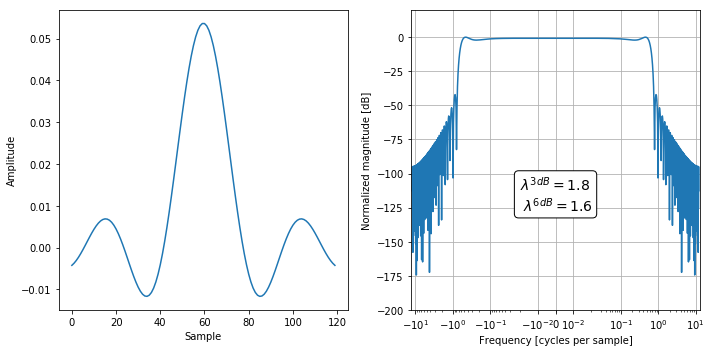

In [12]:
cutoff = 1.5 # A 1.5-day cutoff
dx = 1./24. # Define the sampling period (one day)
wt.set(n=24*5, dim='time', cutoff=cutoff, dx=dx, window='boxcar')
wt.plot()

In [13]:
res_valid = wt.convolve(trim=True)

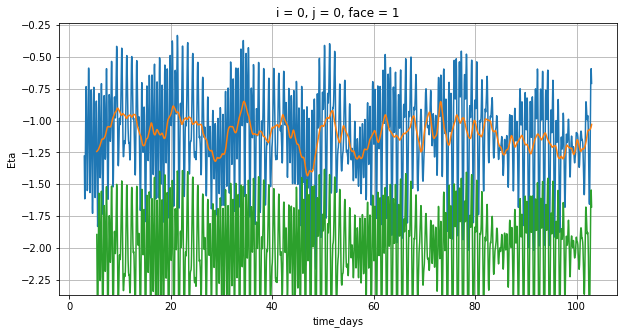

In [14]:
plt.figure(figsize=(10,5))
ax=plt.subplot(111)

toplt =  lds['Eta'].isel(time=slice(0,24*100)).swap_dims({'time': 'time_days'})
toplt.plot(ax=ax)
#
toplt =  res_valid.isel(time=slice(0,24*100)).swap_dims({'time': 'time_days'})
toplt.plot(ax=ax)
#
toplt =  (lds['Eta']-res_valid-2.).isel(time=slice(0,24*100)).swap_dims({'time': 'time_days'})
toplt.plot(ax=ax)


ax.grid()

---

## filtering over the entire tile

In [9]:
lds = ds

In [10]:
wt = lds['Eta'].window

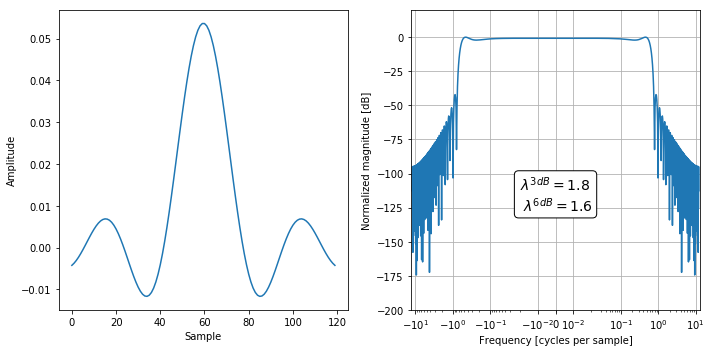

In [11]:
cutoff = 1.5 # A 1.5-day cutoff
dx = 1./24. # Define the sampling period (one day)
wt.set(n=24*5, dim='time', cutoff=cutoff, dx=dx, window='boxcar')
wt.plot()

In [21]:
lds_f = wt.convolve(trim=True)

In [22]:
print(lds)

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 1
  * time       (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 ...
    time_days  (time) float64 3.0 3.042 3.083 3.125 3.167 3.208 3.25 3.292 ...
Data variables:
    Eta        (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 4320, 240)>


In [14]:
print(ds0)

<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 4320, 240)>


Text(0.5,1,'high pass filtered eta')

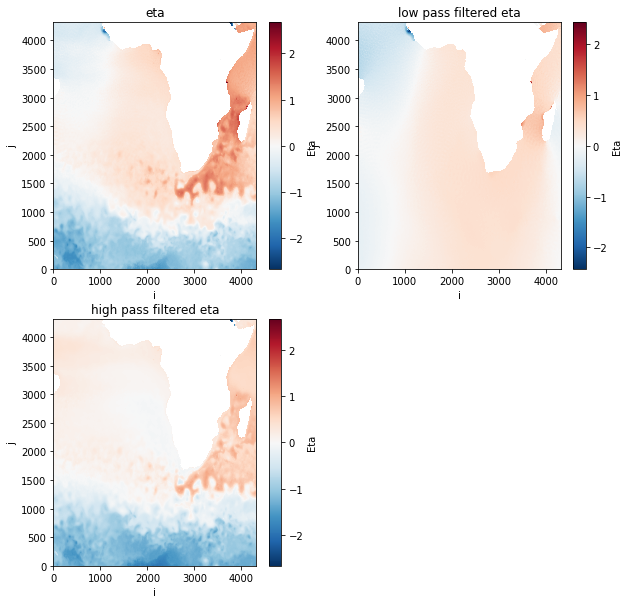

In [15]:
plt.figure(figsize=(10,10))

it=100

eta =  ds0['Eta'].isel(time=it) # 432 file read, because of i chunks
#eta =  lds['Eta'].isel(time=it) # note: xarray open all files in order to load Eta here because of the large chunk along time
eta = eta.persist()

etaf = (lds['Eta']-lds_f).isel(time=it) # 1836 file read
etaf = etaf.persist()

ax=plt.subplot(221)
eta.plot(ax=ax, x='i', y='j')
ax.set_title('eta')

#
ax=plt.subplot(222)
etaf.plot(ax=ax, x='i', y='j')
ax.set_title('low pass filtered eta')

#
ax=plt.subplot(223)
(eta-etaf).plot(ax=ax, x='i', y='j')
ax.set_title('high pass filtered eta')


In [ ]:
# store in netcdf files

Nt = 24*10 # time windows to consider
fsize_bound = 1e20
it = np.arange(lds.time.size/Nt-1).astype(int)*Nt
#it = np.arange(10).astype(int)*Nt # tmp
assert it[-1]+Nt<lds.time.size
#
#for face in range(ds['face'].size):
for i, t in enumerate(it):
    #
    file_out = out_dir+'/%s_filtered_f%02d_t%02d.nc'%(v, face, i)
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        dv = lds_f.isel(time=slice(t,t+Nt))
        #
        dv = dv.chunk({'time': dv['time'].size, 'i': 432, 'j': 432})
        chunksizes = [432, 432, dv['time'].size]
        #
        dv = dv.load() # this may be required in order to prevent pickle related errors
        #
        while True:
            try:
                %time dv.to_netcdf(file_out, mode='w', unlimited_dims=['time'], \
                                   encoding={'Eta': {'chunksizes': chunksizes}})
            except:
                print('Failure')
            break
            #if os.path.isfile(file_out) and os.path.getsize(file_out)>fsize_bound:
            #    #
            #    print('face=%d / i=%d'%(face,i))
            #    break
    else:
        print('face=%d / i=%d - allready processed'%(face,i))

---

In [ ]:
# kill workers
cluster.stop_workers(cluster.jobs)

In [80]:
# add workers
w = cluster.start_workers(10)

In [78]:
# restart workers
client.restart()

Client Scheduler: tcp://10.148.1.0:57813 Dashboard: http://10.148.1.0:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B
